# Dataset
---



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishmotwani/tomato")

print("Path to dataset files:", path)

100%|██████████| 1.37G/1.37G [00:18<00:00, 80.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1


In [2]:

train_dir = path + '/train/'
valid_dir = path + '/valid/'

# Visualization

In [8]:
from google.colab import drive
from tensorflow.keras.models import load_model

drive.mount('/content/drive')
model_eff = load_model('/content/drive/My Drive/New_Models/efficientNetB0.h5')
model_res = load_model('/content/drive/My Drive/New_Models/resnet50.h5')
model_vgg = load_model('/content/drive/My Drive/New_Models/vgg19.h5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Function to get a random image from directory
def get_random_sample_from_directory(test_dir, img_size=(224, 224)):
    class_labels = sorted(os.listdir(test_dir))  # Class names sorted alphabetically

    chosen_class = random.choice(class_labels)
    class_path = os.path.join(test_dir, chosen_class)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)

    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # img_array = img_array / 255.0  # Normalize to [0,1]
    return img_array, chosen_class

def get_gradcam_pp(model, image, layer_name, class_idx):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            conv_outputs, predictions = grad_model(tf.expand_dims(image, axis=0))
            loss = predictions[:, class_idx]

        grads = tape2.gradient(loss, conv_outputs)
    second_grads = tape1.gradient(grads, conv_outputs)

    conv_outputs = conv_outputs[0]
    grads = grads[0]
    second_grads = second_grads[0]

    alpha_num = grads**2
    alpha_denom = 2.0 * grads**2 + conv_outputs * second_grads
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
    alphas = alpha_num / alpha_denom

    weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(0, 1))

    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    # Only normalize heatmap itself for visualization
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (224, 224))
    return heatmap

def apply_heatmap_on_image(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Ensure heatmap is 0-255
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Ensure input image is uint8
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

def visualize_gradcams(models, model_layer_names, model_names, img_array, true_label, class_labels):
    plt.figure(figsize=(5 * (len(models) + 1), 5))

    # Show original image
    plt.subplot(1, len(models) + 1, 1)
    plt.imshow(img_array.astype(np.uint8))
    plt.title(f"True: {true_label}", fontsize=14)
    plt.axis('off')

    for idx, (model, layer_name, model_name) in enumerate(zip(models, model_layer_names, model_names)):
        preds = model.predict(tf.expand_dims(img_array, axis=0), verbose=0)
        pred_label = class_labels[np.argmax(preds)]

        heatmap = get_gradcam_pp(model, img_array, layer_name, np.argmax(preds))
        blended_img = apply_heatmap_on_image(img_array, heatmap)

        plt.subplot(1, len(models) + 1, idx + 2)
        plt.imshow(blended_img.astype(np.uint8))
        plt.title(f"{model_name}\nPred: {pred_label}", fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()



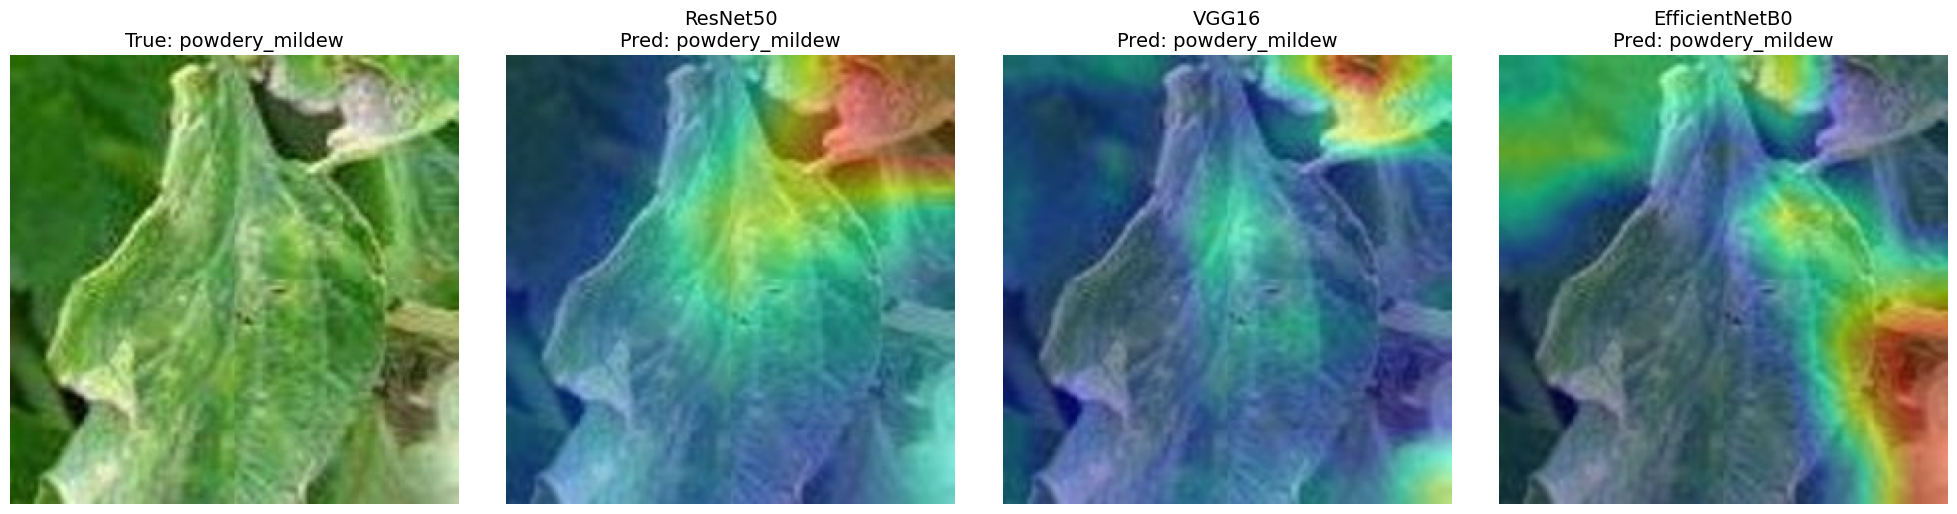

In [22]:

# Assume
models = [model_res, model_vgg, model_eff]
model_layer_names = ['conv5_block3_out','block5_conv4','top_conv']
model_names = ['ResNet50', 'VGG16', 'EfficientNetB0']
class_labels = sorted(os.listdir(valid_dir))

# Get random image
img_array, true_label = get_random_sample_from_directory(valid_dir)

# Visualize
visualize_gradcams(models, model_layer_names, model_names, img_array, true_label, class_labels)



In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

def get_n_images_per_class(test_dir, n=1, img_size=(224, 224)):
    samples = []
    class_folders = sorted(os.listdir(test_dir))

    for class_folder in class_folders:
        class_path = os.path.join(test_dir, class_folder)

        if not os.path.isdir(class_path):
            continue

        img_files = [os.path.join(class_path, img) for img in os.listdir(class_path)
                     if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not img_files:
            continue

        selected_imgs = random.sample(img_files, min(n, len(img_files)))

        for img_path in selected_imgs:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # (1,224,224,3)
            samples.append((img_array, class_folder, img_path))

    return samples



# Assume
models = [model_res, model_vgg, model_eff]
model_layer_names = ['conv5_block3_out','block5_conv4','top_conv']
model_names = ['ResNet50', 'VGG16', 'EfficientNetB0']
class_labels = sorted(os.listdir(valid_dir))


samples = get_n_images_per_class(valid_dir, n=1, img_size=(224, 224))

for img_array, true_label, img_path in samples:
    img_array = np.squeeze(img_array, axis=0)  # (1,224,224,3) -> (224,224,3)
    visualize_gradcams(models, model_layer_names, model_names, img_array, true_label, class_labels)


